In [1]:
import numpy as np
import torch
ora_W = np.load('/h3cstore_ns/jcxie/LISA/nips2024/test_npy/9_self_attn.v_proj_ora_W.npy')
new_W = np.load('/h3cstore_ns/jcxie/LISA/nips2024/test_npy/9_self_attn.v_proj_new_W.npy')
test_inps = np.load('/h3cstore_ns/jcxie/LISA/nips2024/test_npy/9_self_attn.v_proj_test_inps.npy')
test_outs = np.load('/h3cstore_ns/jcxie/LISA/nips2024/test_npy/9_self_attn.v_proj_test_outs.npy')

ora_W = torch.tensor(ora_W).to(torch.float16).cuda()
new_W = torch.tensor(new_W).to(torch.float16).cuda()
test_inps = torch.tensor(test_inps).to(torch.float16)
test_outs = torch.tensor(test_outs).to(torch.float16)

In [2]:
from tqdm import tqdm
import math
import time

lambda_value = []
lambda_abs = []
alphas = []
epss = []
out = []
out_abs = []
errors = []

def get_error(ora_W, new_W, test_inps, test_outs):
    results = 0
    for i in range(test_inps.shape[0]):
        inp = test_inps[i].unsqueeze(0).cuda()
        out = test_outs[i].unsqueeze(0).cuda()
        result = torch.norm((new_W.to(torch.float16) @ inp) - (out)) / torch.norm(out)
        results += result.item()
    results /= test_inps.shape[0]
    return result

def alpha_schedule_exp(k, max_iter=45, alpha_start=0.9, alpha_end=0.99, gamma=5.0):
    # if k >= max_iter:
    #     return alpha_end
    ratio = k / max_iter
    return alpha_end - (alpha_end - alpha_start) * np.exp(-gamma * ratio)

def delta_schedule_exp(k, max_iter=45, alpha_start=0.9, alpha_end=0.99, gamma=5.0):
    if k >= max_iter:
        return alpha_end - alpha_start
    else:
        return alpha_schedule_exp(k, max_iter, alpha_start, alpha_end, gamma) - alpha_start

def alpha_schedule(k, max_iter=45, alpha_start=0.9, alpha_end=0.99):
    if k >= max_iter:
        return alpha_end
    else:
        return alpha_start + (alpha_end - alpha_start) * (k / max_iter)

def dual_ascent_method10(H_A, H_B, W_old, M, beta, alpha, gama, rho, epsilon=1e-5, max_iter=10, lambda_zero=False, percdamp=.01):
    M = M.to(torch.float32)
    H_A = H_A.to(torch.float32)
    H_B = H_B.to(torch.float32)
    W_old = W_old.to(torch.float32)
    
    # 初始化 W 和 Lambda
    W = W_old.clone()
    if lambda_zero:
        Lambda = torch.zeros_like(W)
    # else:
    #     term1 = beta * (torch.mm(W, H_A) - H_B)
    #     term2 = alpha * (W - W_old)
    #     Lambda = -M * (term1 + term2)
    I = torch.eye(H_A.shape[0], device=H_A.device)
    A = (1-alpha) * H_A + alpha * I

    A_start = torch.linalg.cholesky(A)
    A_start = torch.cholesky_inverse(A_start)
    
    A1 = -(A_start @ (I - H_A) @ A_start)
    A2 = (-A1) @ (I - H_A) @ A_start
    A3 = (-A2) @ (I - H_A) @ A_start


    alpha_start = alpha
    for k in tqdm(range(max_iter)):
        alpha = alpha_schedule_exp(k, alpha_start=alpha_start)
        delta = alpha - alpha_start

        if k % 1 == 0 and k < 30:
            alpha_start = alpha

            A = (1-alpha) * H_A + alpha * I

            A_start = torch.linalg.cholesky(A)
            A_start = torch.cholesky_inverse(A_start)
            
            A1 = -(A_start @ (I - H_A) @ A_start)
            A2 = (-A1) @ (I - H_A) @ A_start
            A3 = (-A2) @ (I - H_A) @ A_start



        W_prev = W.clone()

        B = (1-alpha-delta) * H_B + (alpha + delta) * W_prev
        B = B - Lambda

        # A_inv = (1-alpha-delta) * H_A + (alpha + delta) * I
        # A_inv = torch.linalg.cholesky(A_inv)
        # A_inv = torch.cholesky_inverse(A_inv)

        W = B @ (A_start + delta * A1 + delta**2 * A2 + delta**3 * A3)
        # W = B @ A_inv

        # print("二阶近似误差",torch.norm(((A_start + delta * A1 + delta**2 * A2) - A_inv)))


        Lambda = Lambda + rho * (M * W)

        lambda_value.append(Lambda.mean().item())
        lambda_abs.append(Lambda.abs().mean().item())
        out.append((M * W).mean().item())
        out_abs.append((M * W.abs()).mean().item())
        epss.append(torch.norm(W - W_prev).item())
        errors.append(get_error(ora_W, W, test_inps, test_outs).item())
        # W = W - M * W
        # 收敛判断

        if k % 5 == 0 and k > 0:
            

            # print( (W.to(torch.float16) @ test_inps[0].cuda() - test_outs[0][0].cuda()).abs().max(), (W.to(torch.float16) @ test_inps[0].cuda() - test_outs[0][0].cuda()).abs().mean())
            # print(torch.norm(W - W_prev))
            if torch.norm(W - W_prev) < epsilon:
                print( (W.to(torch.float16) @ test_inps[0].cuda() - test_outs[0][0].cuda()).abs().max(), (W.to(torch.float16) @ test_inps[0].cuda() - test_outs[0][0].cuda()).abs().mean())
                print(f"Converged at iteration {k}")
                print(torch.norm(W - W_prev))
                break

        # if k % 10 == 0 :
        #     print(torch.norm(W - W_prev))
    W = W - M * W
    return W.to(torch.float16)

test_x = test_inps[0]
test_y = test_outs[0][0]

H_A = torch.zeros((test_x.shape[-2], test_x.shape[-2]), device="cuda")
H_B = torch.zeros((test_y.shape[-2], test_x.shape[-2]), device="cuda")
nsamples = 0
for i in range(120):
    H_A *= nsamples / (nsamples + 1)
    H_B *= nsamples / (nsamples + 1)

    nsamples += 1

    H_A += (math.sqrt(2 / nsamples) * test_inps[i].cuda().to(torch.float32)) @ (math.sqrt(2 / nsamples) * test_inps[i].cuda().to(torch.float32)).T
    H_B += (math.sqrt(2 / nsamples) * test_outs[i][0].cuda().to(torch.float32)) @ (math.sqrt(2 / nsamples) * test_inps[i].cuda().to(torch.float32)).T

    

M = (new_W == 0).to(torch.float32).to(H_B.device)
print(M.device)
# M = torch.zeros_like(M).to(torch.float32).cuda()
print((M == 0).sum() / M.numel())
W_old = new_W.clone().to(H_B.device)
beta = 0.01
alpha = 0.9
gama = 0.0000
rho = 1


start = time.time()

W_update = dual_ascent_method10(H_A, H_B, W_old, M, beta, alpha, gama, rho, lambda_zero=True, max_iter=50)
print('time', time.time() - start)

cuda:0
tensor(0.3000, device='cuda:0')


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]

time 87.0017957687378


数据长度： range(0, 21)
21 21 21 21 21


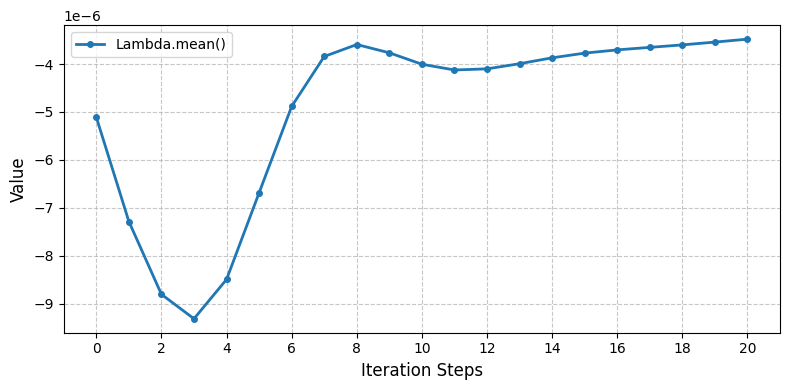

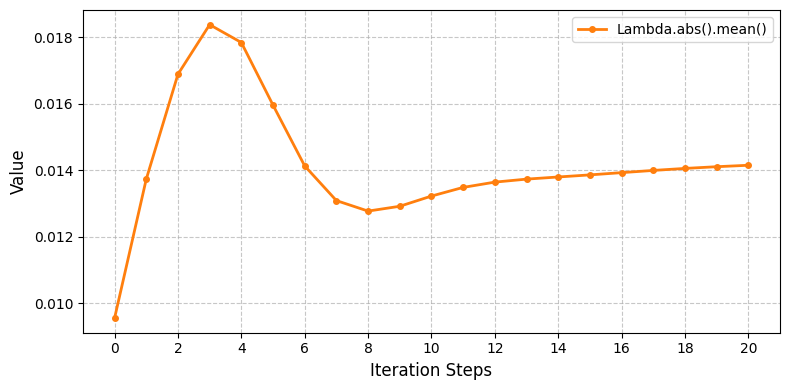

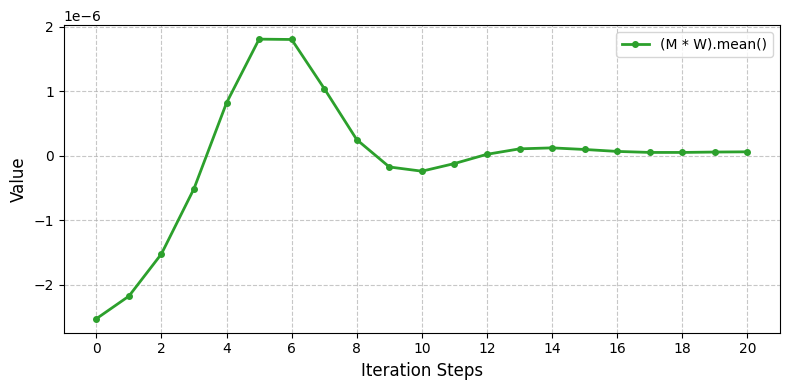

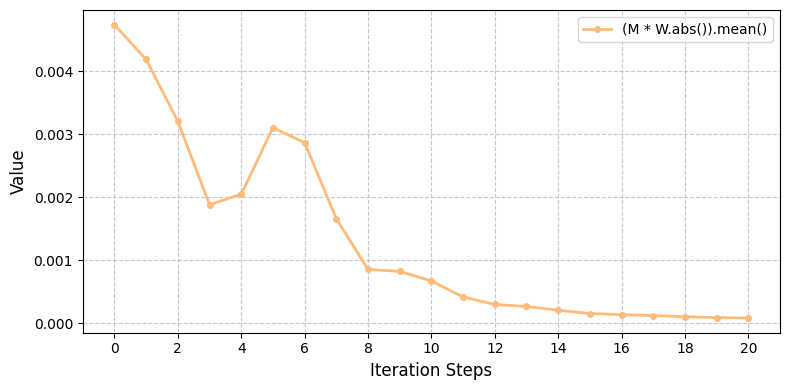

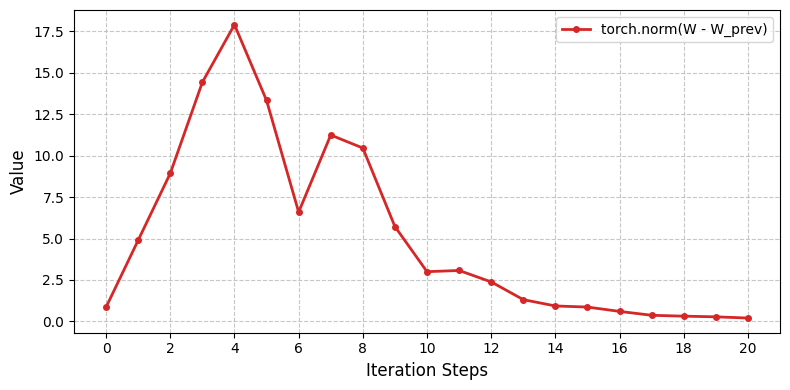

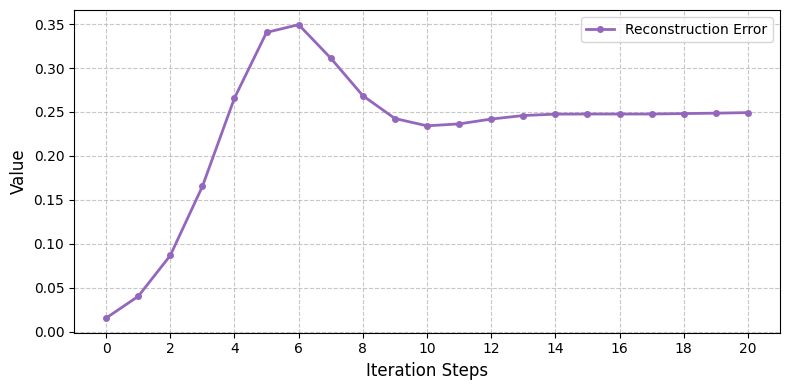

In [11]:
lambda_value1 = lambda_value[1:22]
lambda_abs1 = lambda_abs[1:22]
out1 = out[1:22]
out_abs1 = out_abs[1:22]
epss1 = epss[1:22]
errors1 = errors[1:22]
num_steps1 = len(lambda_value1)  # 获取迭代步骤数

import matplotlib.pyplot as plt
# plt.style.use('seaborn-darkgrid')  # 使用seaborn的样式


data_list = [
    (lambda_value1, 'Lambda.mean()', '#1f77b4'),
    (lambda_abs1, 'Lambda.abs().mean()', '#ff7f0e'),
    (out1, '(M * W).mean()', '#2ca02c'),
    (out_abs1, '(M * W.abs()).mean()', '#ffbb78'),
    (epss1, 'torch.norm(W - W_prev)', '#d62728'),
    (errors1, 'Reconstruction Error', '#9467bd')
]


x = range(num_steps1)  # x轴为迭代步骤
print("数据长度：" ,x)
print(len(lambda_value1), len(lambda_abs1), len(out1), len(epss1), len(errors1))

# 循环绘制五张图
for i, (data, label, color) in enumerate(data_list, 1):
    plt.figure(figsize=(8, 4))  # 每张图的尺寸
    
    # 绘制单条折线
    plt.plot(x, data, 'o-', color=color, label=label, linewidth=2, markersize=4)
    
    # 添加标签和图例
    plt.xlabel('Iteration Steps', fontsize=12)  # x轴标签（迭代步骤）
    plt.ylabel('Value', fontsize=12)  # y轴标签（数值）
    plt.legend(fontsize=10)  # 图例
    
    # 添加网格
    plt.grid(linestyle='--', alpha=0.7)
    plt.xticks(range(0, 22, 2))
    # 调整布局
    plt.tight_layout()
    
    # 保存图片（可选，如需保存可取消注释）
    # plt.savefig(f'{label.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    
    # 显示图片
    plt.show()

In [5]:
print((W_update == 0).sum() / W_update.numel())
for i in [0, 32, 63, 122, 123, 124]:
    # W_update = W_update - M.to(torch.float16) * W_update
    print(test_outs[i][0].abs().max(), test_outs[i][0].abs().mean())
    print(i, (W_update @ test_inps[i].cuda() - test_outs[i][0].cuda()).abs().max(), (W_update @ test_inps[i].cuda() - test_outs[i][0].cuda()).abs().mean())
    print(i, (new_W.to(H_B.device) @ test_inps[i].cuda() - test_outs[i][0].cuda()).abs().max(), (new_W.to(H_B.device) @ test_inps[i].cuda() - test_outs[i][0].cuda()).abs().mean())
    # W_update2 = W_update - M.to(torch.float16) * W_update
    # print(i, (W_update2 @ test_inps[i].cuda() - test_outs[i][0].cuda()).abs().max(), (W_update2 @ test_inps[i].cuda() - test_outs[i][0].cuda()).abs().mean())
    # print("-----------")
    # print((new_W @ test_inps[i]).abs().max(), (new_W @ test_inps[i]).abs().mean())
    # print((W_update2 @ test_inps[i]).abs().max(), (W_update2 @ test_inps[i]).abs().mean())
    # print(test_outs[i][0].abs().max(), test_outs[i][0].abs().mean())
    print("-------------------------------------------------------------------------")

tensor(0.7000, device='cuda:0')
tensor(3.9316, dtype=torch.float16) tensor(0.2715, dtype=torch.float16)
0 tensor(0.5762, device='cuda:0', dtype=torch.float16) tensor(0.0687, device='cuda:0', dtype=torch.float16)
0 tensor(0.5742, device='cuda:0', dtype=torch.float16) tensor(0.0740, device='cuda:0', dtype=torch.float16)
-------------------------------------------------------------------------
tensor(5.1016, dtype=torch.float16) tensor(0.2737, dtype=torch.float16)
32 tensor(0.8398, device='cuda:0', dtype=torch.float16) tensor(0.0703, device='cuda:0', dtype=torch.float16)
32 tensor(0.8164, device='cuda:0', dtype=torch.float16) tensor(0.0758, device='cuda:0', dtype=torch.float16)
-------------------------------------------------------------------------
tensor(3.5605, dtype=torch.float16) tensor(0.2708, dtype=torch.float16)
63 tensor(0.6562, device='cuda:0', dtype=torch.float16) tensor(0.0796, device='cuda:0', dtype=torch.float16)
63 tensor(0.6562, device='cuda:0', dtype=torch.float16) tenso

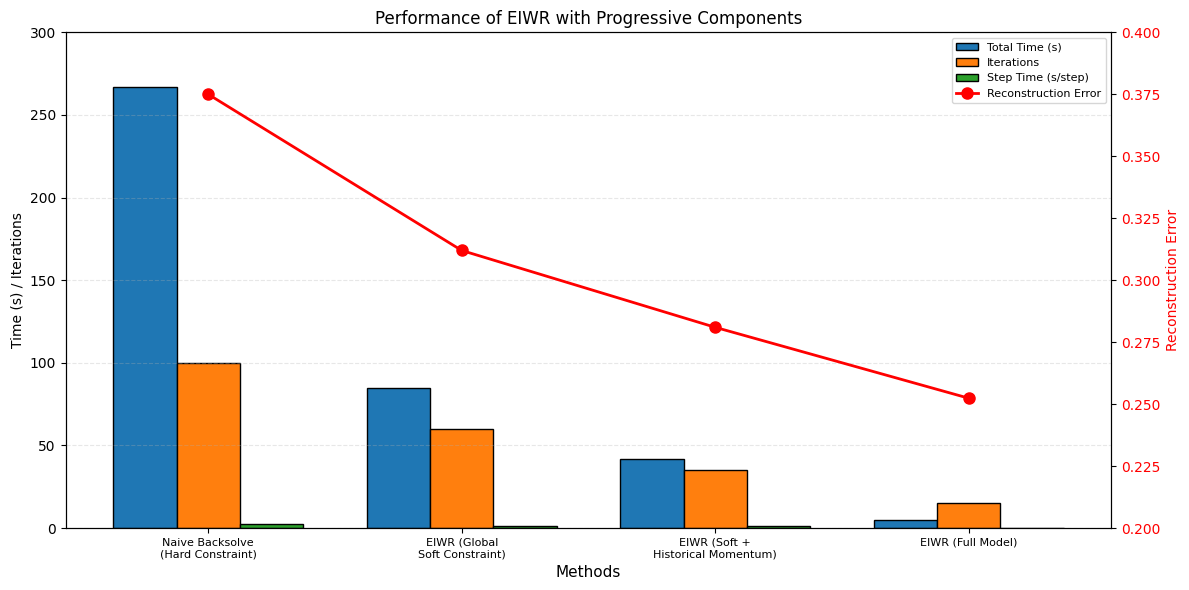

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --------------------------
# 1. 数据准备（基于论文实验逻辑）
# --------------------------
# 方法名称（四组对比）
methods = [
    "Naive Backsolve\n(Hard Constraint)",
    "EIWR (Global\nSoft Constraint)",
    "EIWR (Soft +\nHistorical Momentum)",
    "EIWR (Full Model)"
]

# 每组三个柱子的数据（左纵轴）
# 数据逻辑：随创新点叠加，时间和迭代轮次递减（符合论文效率提升结论）
total_time = [267, 85, 42, 4.8]  # 总体时间开销（秒）
iterations = [100, 60, 35, 15]   # 迭代轮次（次）
step_time = [2.67, 1.42, 1.20, 0.32]  # 单步时间开销（秒/步）

# 误差数据（右纵轴，折线图）
# 数据逻辑：随创新点叠加，误差降低（符合论文性能恢复结论）
error = [0.3750, 0.3120, 0.2810, 0.2524]  # 重构误差（相对值）


# --------------------------
# 2. 绘图设置
# --------------------------
plt.figure(figsize=(12, 6))
# 创建双坐标轴
ax1 = plt.gca()
ax2 = ax1.twinx()

# 柱状图位置与宽度
x = np.arange(len(methods))
width = 0.25  # 单个柱子宽度


# --------------------------
# 3. 绘制柱状图（左纵轴：时间与迭代）
# --------------------------
# 总体时间开销（蓝色）
rects1 = ax1.bar(x - width, total_time, width, label='Total Time (s)', 
                 color='#1f77b4', edgecolor='black')
# 迭代轮次（橙色）
rects2 = ax1.bar(x, iterations, width, label='Iterations', 
                 color='#ff7f0e', edgecolor='black')
# 单步时间开销（绿色）
rects3 = ax1.bar(x + width, step_time, width, label='Step Time (s/step)', 
                 color='#2ca02c', edgecolor='black')


# --------------------------
# 4. 绘制误差折线图（右纵轴）
# --------------------------
ax2.plot(x, error, 'ro-', linewidth=2, markersize=8, label='Reconstruction Error')
ax2.set_ylabel('Reconstruction Error', fontsize=10, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.2, 0.4)  # 误差范围（符合论文中0.2-0.4的实际值）


# --------------------------
# 5. 标注与美化
# --------------------------
# 左纵轴设置（时间与迭代）
ax1.set_xlabel('Methods', fontsize=11)
ax1.set_ylabel('Time (s) / Iterations', fontsize=10)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=8)
ax1.set_ylim(0, 300)  # 时间轴范围（覆盖最大时间267秒）

# 标题（关联论文核心创新）
plt.title('Performance of EIWR with Progressive Components', fontsize=12)

# 图例（区分柱状图与折线图）
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

# 添加网格（增强可读性）
ax1.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

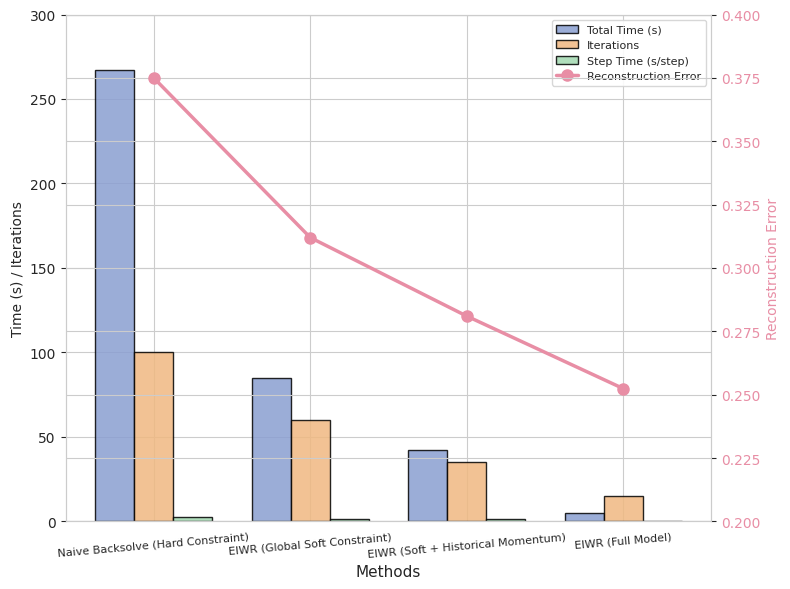

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------------------
# 1. 字体设置（New Times Roman）
# --------------------------
plt.rcParams["font.family"] = ["Times New Roman", "serif"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# --------------------------
# 2. 数据准备（保持论文实验逻辑）
# --------------------------
methods = [
    "Naive Backsolve (Hard Constraint)",
    "EIWR (Global Soft Constraint)",
    "EIWR (Soft + Historical Momentum)",
    "EIWR (Full Model)"
]

# 效率指标数据（左纵轴）
total_time = [267, 85, 42, 4.8]    # 总体时间（秒）
iterations = [100, 60, 35, 15]     # 迭代轮次（次）
step_time = [2.67, 1.42, 1.20, 0.32]  # 单步时间（秒/步）

# 性能指标数据（右纵轴）
error = [0.3750, 0.3120, 0.2810, 0.2524]  # 重构误差


# --------------------------
# 3. 莫奈色系定义（使用指定颜色）
# --------------------------
monet_colors = {
    'wanda': '#8A9FD1',       # 淡紫色（用于总体时间）
    'sparsegpt': '#F0B881',   # 暖粉色（用于迭代轮次）
    'dual_wanda': '#A3D9B1',  # 薄荷绿（用于单步时间）
    'dual_sparsegpt': '#E88EA5' # 浅玫瑰色（用于误差线）
}


# --------------------------
# 4. 绘图设置
# --------------------------
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # 保持网格背景但弱化干扰

ax1 = plt.gca()
ax2 = ax1.twinx()  # 双纵轴

x = np.arange(len(methods))
width = 0.25  # 柱子宽度


# --------------------------
# 5. 绘制柱状图（左纵轴：效率指标）
# --------------------------
# 总体时间开销（淡紫色）
rects1 = ax1.bar(
    x - width, total_time, width, 
    label='Total Time (s)', 
    color=monet_colors['wanda'], edgecolor='black', alpha=0.85
)
# 迭代轮次（暖粉色）
rects2 = ax1.bar(
    x, iterations, width, 
    label='Iterations', 
    color=monet_colors['sparsegpt'], edgecolor='black', alpha=0.85
)
# 单步时间开销（薄荷绿）
rects3 = ax1.bar(
    x + width, step_time, width, 
    label='Step Time (s/step)', 
    color=monet_colors['dual_wanda'], edgecolor='black', alpha=0.85
)


# --------------------------
# 6. 绘制误差折线图（右纵轴：性能指标）
# --------------------------
ax2.plot(
    x, error, 'o-', 
    linewidth=2.5, markersize=8, 
    color=monet_colors['dual_sparsegpt'], 
    markerfacecolor=monet_colors['dual_sparsegpt'], 
    label='Reconstruction Error'
)
ax2.set_ylabel('Reconstruction Error', fontsize=10, color=monet_colors['dual_sparsegpt'])
ax2.tick_params(axis='y', labelcolor=monet_colors['dual_sparsegpt'])
ax2.set_ylim(0.2, 0.4)  # 误差范围匹配论文数据


# --------------------------
# 7. 标注与美化（学术图表规范）
# --------------------------
# 左纵轴设置
ax1.set_xlabel('Methods', fontsize=11)
ax1.set_ylabel('Time (s) / Iterations', fontsize=10)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=8, rotation=5)  # 轻微旋转避免文字重叠
ax1.set_ylim(0, 300)  # 覆盖最大时间值

# # 标题（关联论文核心创新）
# plt.title('EIWR Performance with Progressive Components', fontsize=12, pad=10)

# 图例（清晰区分所有指标）
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2, 
    loc='upper right', fontsize=8,
    frameon=True, framealpha=0.9,  # 白色背景增强可读性
    edgecolor='lightgray'
)

# 网格线（弱化处理，不干扰主体）
ax1.grid(axis='y', linestyle='--', alpha=0.2, color='gray')

plt.tight_layout()
plt.show()

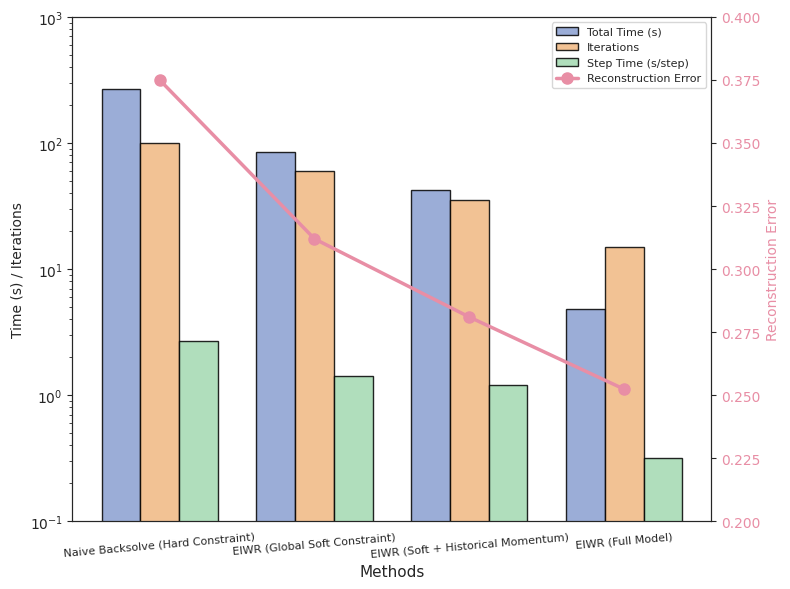

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------------------
# 1. 字体设置（New Times Roman）
# --------------------------
plt.rcParams["font.family"] = ["Times New Roman", "serif"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# --------------------------
# 2. 数据准备（保持论文实验逻辑）
# --------------------------
methods = [
    "Naive Backsolve (Hard Constraint)",
    "EIWR (Global Soft Constraint)",
    "EIWR (Soft + Historical Momentum)",
    "EIWR (Full Model)"
]

# 效率指标数据（左纵轴）
total_time = [267, 85, 42, 4.8]    # 总体时间（秒）
iterations = [100, 60, 35, 15]     # 迭代轮次（次）
step_time = [2.67, 1.42, 1.20, 0.32]  # 单步时间（秒/步）

# 性能指标数据（右纵轴）
error = [0.3750, 0.3120, 0.2810, 0.2524]  # 重构误差


# --------------------------
# 3. 莫奈色系定义（使用指定颜色）
# --------------------------
monet_colors = {
    'wanda': '#8A9FD1',       # 淡紫色（用于总体时间）
    'sparsegpt': '#F0B881',   # 暖粉色（用于迭代轮次）
    'dual_wanda': '#A3D9B1',  # 薄荷绿（用于单步时间）
    'dual_sparsegpt': '#E88EA5' # 浅玫瑰色（用于误差线）
}


# --------------------------
# 4. 绘图设置
# --------------------------
plt.figure(figsize=(8, 6))
sns.set_style("white")  # 移除默认网格线

ax1 = plt.gca()
ax2 = ax1.twinx()  # 双纵轴

x = np.arange(len(methods))
width = 0.25  # 柱子宽度


# --------------------------
# 5. 绘制柱状图（左纵轴：效率指标）
# --------------------------
# 总体时间开销（淡紫色）
rects1 = ax1.bar(
    x - width, total_time, width, 
    label='Total Time (s)', 
    color=monet_colors['wanda'], edgecolor='black', alpha=0.85
)
# 迭代轮次（暖粉色）
rects2 = ax1.bar(
    x, iterations, width, 
    label='Iterations', 
    color=monet_colors['sparsegpt'], edgecolor='black', alpha=0.85
)
# 单步时间开销（薄荷绿）
rects3 = ax1.bar(
    x + width, step_time, width, 
    label='Step Time (s/step)', 
    color=monet_colors['dual_wanda'], edgecolor='black', alpha=0.85
)


# --------------------------
# 6. 绘制误差折线图（右纵轴：性能指标）
# --------------------------
ax2.plot(
    x, error, 'o-', 
    linewidth=2.5, markersize=8, 
    color=monet_colors['dual_sparsegpt'], 
    markerfacecolor=monet_colors['dual_sparsegpt'], 
    label='Reconstruction Error'
)
ax2.set_ylabel('Reconstruction Error', fontsize=10, color=monet_colors['dual_sparsegpt'])
ax2.tick_params(axis='y', labelcolor=monet_colors['dual_sparsegpt'])
ax2.set_ylim(0.2, 0.4)  # 误差范围匹配论文数据


# --------------------------
# 7. 标注与美化（核心调整：对数轴+去网格）
# --------------------------
# 左纵轴设置（核心调整：改为对数刻度，范围0.1-1000）
ax1.set_xlabel('Methods', fontsize=11)
ax1.set_ylabel('Time (s) / Iterations', fontsize=10)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=8, rotation=5)  # 轻微旋转避免文字重叠
ax1.set_yscale('log')  # 对数刻度
ax1.set_ylim(0.1, 1000)  # 范围0.1-1000

# 图例（清晰区分所有指标）
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2, 
    loc='upper right', fontsize=8,
    frameon=True, framealpha=0.9,
    edgecolor='lightgray'
)

# 去掉网格线（已通过sns.set_style("white")实现，此处确认无网格）

plt.tight_layout()
plt.show()

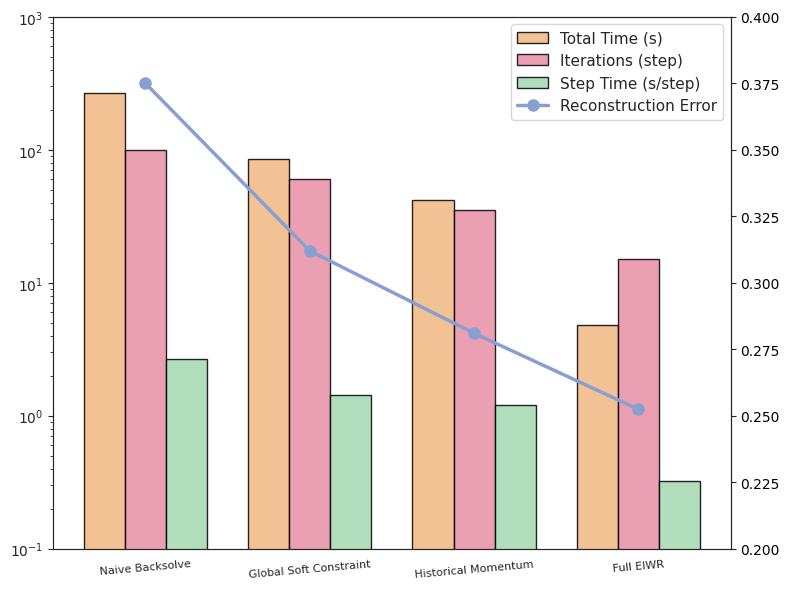

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------------------
# 1. 字体设置（New Times Roman）
# --------------------------
plt.rcParams["font.family"] = ["Times New Roman", "serif"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# --------------------------
# 2. 数据准备（保持论文实验逻辑）
# --------------------------
methods = [
    "Naive Backsolve",
    "Global Soft Constraint",
    "Historical Momentum",
    "Full EIWR"
]

# 效率指标数据（左纵轴）
total_time = [267, 85, 42, 4.8]    # 总体时间（秒）
iterations = [100, 60, 35, 15]     # 迭代轮次（次）
step_time = [2.67, 1.42, 1.20, 0.32]  # 单步时间（秒/步）

# 性能指标数据（右纵轴）
error = [0.3750, 0.3120, 0.2810, 0.2524]  # 重构误差


# --------------------------
# 3. 莫奈色系定义（使用指定颜色）
# --------------------------
monet_colors = {
    'wanda': '#F0B881',       # 淡紫色（用于总体时间）
    'sparsegpt': '#E88EA5',   # 暖粉色（用于迭代轮次）
    'dual_wanda': '#A3D9B1',  # 薄荷绿（用于单步时间）
    'dual_sparsegpt': "#8A9FD1" # 浅玫瑰色（用于误差线）
}



# -------------------------- #E88EA5 F0B881 8A9FD1
# 4. 绘图设置
# --------------------------
plt.figure(figsize=(8, 6))
sns.set_style("white")  # 移除默认网格线

ax1 = plt.gca()
ax2 = ax1.twinx()  # 双纵轴

x = np.arange(len(methods))
width = 0.25  # 柱子宽度


# --------------------------
# 5. 绘制柱状图（左纵轴：效率指标）
# --------------------------
# 总体时间开销（淡紫色）
rects1 = ax1.bar(
    x - width, total_time, width, 
    label='Total Time (s)', 
    color=monet_colors['wanda'], edgecolor='black', alpha=0.85
)
# 迭代轮次（暖粉色）
rects2 = ax1.bar(
    x, iterations, width, 
    label='Iterations (step)', 
    color=monet_colors['sparsegpt'], edgecolor='black', alpha=0.85
)
# 单步时间开销（薄荷绿）
rects3 = ax1.bar(
    x + width, step_time, width, 
    label='Step Time (s/step)', 
    color=monet_colors['dual_wanda'], edgecolor='black', alpha=0.85
)


# --------------------------
# 6. 绘制误差折线图（右纵轴：性能指标）
# --------------------------
ax2.plot(
    x, error, 'o-', 
    linewidth=2.5, markersize=8, 
    color=monet_colors['dual_sparsegpt'], 
    markerfacecolor=monet_colors['dual_sparsegpt'], 
    label='Reconstruction Error'
)
# 右侧坐标轴改为黑色（核心调整）
# ax2.set_ylabel('Reconstruction Error', fontsize=10, color='black')  # 标签黑色
ax2.tick_params(axis='y', labelcolor='black')  # 刻度文字黑色
ax2.set_ylim(0.2, 0.4)  # 误差范围匹配论文数据


# --------------------------
# 7. 标注与美化
# --------------------------
# 左纵轴设置
# ax1.set_xlabel('Methods', fontsize=11)
# ax1.set_ylabel('Time (s) / Iterations', fontsize=10)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=8, rotation=5)
ax1.set_yscale('log')  # 对数刻度
ax1.set_ylim(0.1, 1000)

# 图例调整（大小通过fontsize控制，位置优化）
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2, 
    loc='upper right',
    fontsize=11,  # 图例文字大小（默认8，调大到9更清晰）
    frameon=True, 
    framealpha=0.9,
    edgecolor='lightgray',
    borderaxespad=0.5  # 图例与坐标轴的距离
)

plt.tight_layout()
plt.show()

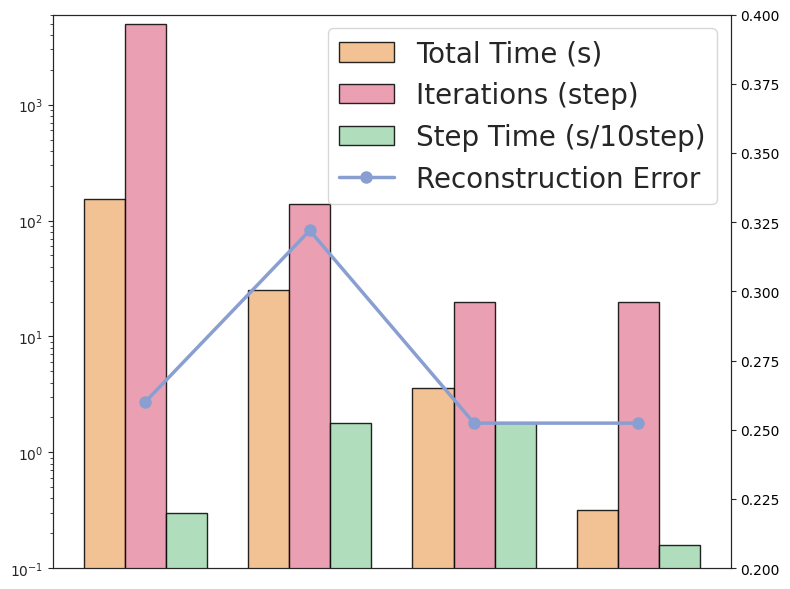

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------------------
# 1. 字体设置（New Times Roman）
# --------------------------
plt.rcParams["font.family"] = ["Times New Roman", "serif"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# --------------------------
# 2. 数据准备（保持论文实验逻辑）
# --------------------------
methods = [  # 标签将被隐藏，仅用于数据定位
    "Naive Backsolve",
    "Global Soft Constraint",
    "Historical Momentum",
    "Full EIWR"
]

# 效率指标数据（左纵轴）
total_time = [153, 25.2, 3.6, 0.32]    # 总体时间（秒）
iterations = [5012, 140, 20, 20]     # 迭代轮次（次）
step_time = [0.3, 1.8, 1.8, 0.16]  # 单步时间（秒/步）

# 性能指标数据（右纵轴）
error = [0.2601, 0.3220, 0.2524, 0.2524]  # 重构误差


# --------------------------
# 3. 莫奈色系定义（使用指定颜色）
# --------------------------
monet_colors = {
    'wanda': '#F0B881',       # 暖粉色（用于总体时间）
    'sparsegpt': '#E88EA5',   # 浅玫瑰色（用于迭代轮次）
    'dual_wanda': '#A3D9B1',  # 薄荷绿（用于单步时间）
    'dual_sparsegpt': "#8A9FD1" # 淡紫色（用于误差线）
}


# --------------------------
# 4. 绘图设置
# --------------------------
plt.figure(figsize=(8, 6))
sns.set_style("white")  # 移除默认网格线

ax1 = plt.gca()
ax2 = ax1.twinx()  # 双纵轴

x = np.arange(len(methods))
width = 0.25  # 柱子宽度


# --------------------------
# 5. 绘制柱状图（左纵轴：效率指标）
# --------------------------
# 总体时间开销
rects1 = ax1.bar(
    x - width, total_time, width, 
    label='Total Time (s)', 
    color=monet_colors['wanda'], edgecolor='black', alpha=0.85
)
# 迭代轮次
rects2 = ax1.bar(
    x, iterations, width, 
    label='Iterations (step)', 
    color=monet_colors['sparsegpt'], edgecolor='black', alpha=0.85
)
# 单步时间开销
rects3 = ax1.bar(
    x + width, step_time, width, 
    label='Step Time (s/10step)', 
    color=monet_colors['dual_wanda'], edgecolor='black', alpha=0.85
)


# --------------------------
# 6. 绘制误差折线图（右纵轴：性能指标）
# --------------------------
ax2.plot(
    x, error, 'o-', 
    linewidth=2.5, markersize=8, 
    color=monet_colors['dual_sparsegpt'], 
    markerfacecolor=monet_colors['dual_sparsegpt'], 
    label='Reconstruction Error'
)
ax2.tick_params(axis='y', labelcolor='black')  # 右侧刻度黑色
ax2.set_ylim(0.2, 0.4)


# --------------------------
# 7. 标注与美化（核心：去掉methods对应标签）
# --------------------------
ax1.set_xticks(x)
ax1.set_xticklabels([])  # 清空x轴刻度标签（即去掉methods对应的文字）
ax1.set_yscale('log')
ax1.set_ylim(0.1, 6000)

# 图例调整
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2, 
    loc='upper right',
    fontsize=20,
    frameon=True, 
    framealpha=0.9,
    edgecolor='lightgray'
)

plt.tight_layout()

plt.savefig('/h3cstore_ns/jcxie/LISA/nips2024/get_plt/img/eiwr_performance.svg', dpi=1000, bbox_inches='tight')  # 保存图片
plt.show()